# Demo for "A Bregman Method for Structure Learning on Sparse Directed Acyclic Graphs"

This notebook provides a quick code demo for AISTATS 2021's submission "A Bregman Method for Structure Learning on Sparse Directed Acyclic Graphs"

### Imports

In [1]:
# Math
import numpy as np
import scipy
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Graph
import networkx as nx

# Custom - data_gen
from data_gen import gen_graph, sample_lin_scms
# Custom - algo
from bregman_solver import BregmanSolver
# Custom - metrics
from metrics import compare_graphs

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Synthetic graph generation 

We generate a synthetic graph $G$ (here a Scale-Free graph with 50 nodes)

##### Constants

In [2]:
graph_type = "scale-free" # choose between "scale-free" and "erdos-renyi"
n = 50 # number of nodes
noise_type = "exp" # or "gumbel" or "gaussian"

In [3]:
G, adj_matrix = gen_graph(graph_type, n, mean_deg=4)

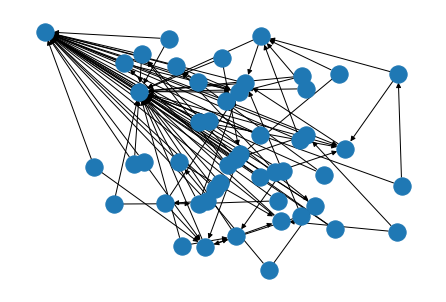

In [4]:
nx.draw(G)

### Synthetic data generation

We sample $m=200$ i.i.d. samples distributed according to the SCM:

$$X = XW^* + E$$

where $X\in\mathbb{R}^{m\times n}$ is the sample matrix, $W^*\in\mathbb{R}^{n\times n}$ is the adjacency matrix of graph $G$ and $E \sim^{\text{i.i.d.}} \exp(1)$

In [5]:
X, w_opt, _ = sample_lin_scms(graph_type, noise_type, adj_matrix, nb_samples=200)

## Learning

We now use our algorithm to recover the adjacency matrix from $X$.

In [6]:
alg = BregmanSolver(version="pos", dagness_exp=0.1/n, dagness_pen=1e2, l1_pen=1e-2, eps=1e-6, 
                    logging=True, mosek=True, max_iter=1000)
%time Wk = alg.run(X)

Done in 49.830816984176636 s and 68 iterations
CPU times: user 1min 2s, sys: 18.1 s, total: 1min 20s
Wall time: 49.9 s


In [7]:
compare_graphs(adj_matrix, np.abs(Wk)>=0.5)

Number of edges in ground truth graph 97.0
Number of edges in estimation 97
Correct edges 97.0
Reversed edges 0.0
Missing edges 0.0
Extra edges 0.0
SHD 0.0


(97.0, 0.0, 0.0, 0.0, 0.0)

Our algorithm managed to learn the graph perfectly in 49.9s (while keeping a log of different objectives).

To run NOTEARS, download the repository from https://github.com/xunzheng/notears in the same folder as this notebook. 

In [10]:
# Importing no tears if in parent folder
if True:
    import os,sys,inspect
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    parentdir = os.path.dirname(currentdir)
    sys.path.insert(0,parentdir) 

from notears.notears.linear import notears_linear

In [11]:
%time W_notears = notears_linear(X, 1e-5, "l2")



CPU times: user 6min 7s, sys: 7.66 s, total: 6min 15s
Wall time: 4min 5s


In [12]:
compare_graphs(adj_matrix, np.abs(W_notears)>=0.5)

Number of edges in ground truth graph 97.0
Number of edges in estimation 102
Correct edges 92.0
Reversed edges 1.0
Missing edges 4.0
Extra edges 9.0
SHD 14.0


(92.0, 9.0, 1.0, 4.0, 14.0)

On the other hand, NOTEARS didn't learn the graph to perfection, making 14 mistakes (missing, extra or reversed edges) and took 4min5s instead.

## Extra visualisations

We provide extra visualisations that could be of interest to the reader. The first one shows convergence of different part of the objective with iteration of our algorithm. 

In [13]:
logging = alg.log_dict

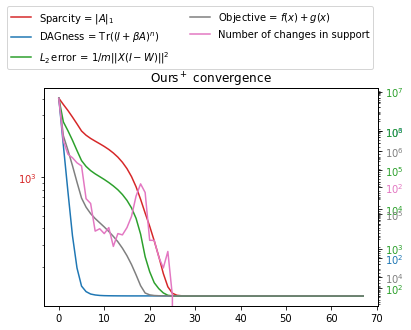

In [19]:
values_l2error = logging["l2_error"]
values_l1pen = logging["l1_val"] 
values_dagness = logging["dag_constraint"]
values_obj = values_l2error + logging["dagness_pen"] * values_dagness + logging["l1_pen"] * values_l1pen
logging["obj"] = values_obj
values_change_support = logging["nb_change_support"]

fig, ax1 = plt.subplots()

color = 'tab:red'
l1 = ax1.plot(values_l1pen, label = "Sparcity = $\|A\|_1$", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
l2 = ax2.plot(values_dagness, label="DAGness = $\mathrm{Tr}((I+\\beta A)^n)$", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
l3 = ax3.plot(values_l2error, color=color, label='$L_2\mathrm{\,error\,=\,}1/m||X (I-W)||^2$')
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")

ax4 = ax1.twinx()
color = 'tab:grey'
l4 = ax4.plot(values_obj, color=color, label='Objective = $f(x)+g(x)$')
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_yscale("log")

ax5 = ax1.twinx()
color = 'tab:pink'
l5 = ax5.plot(values_change_support, color=color, label='Number of changes in support')
ax5.tick_params(axis='y', labelcolor=color)
ax5.set_yscale("log")

lines = l1 + l2 + l3 + l4 + l5
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, ncol=2,  bbox_to_anchor=(1, 1.4))
plt.title("$\mathrm{Ours}^+$ convergence");

The second one is a mere visualisation of the output as a heatmap.

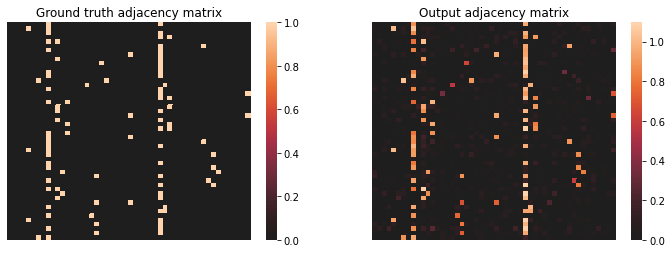

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(w_opt, center=0, ax=axs[0]); axs[0].set_xticks([]);  axs[0].set_yticks([]); 
axs[0].set_title("Ground truth adjacency matrix");
sns.heatmap(Wk, center=0, ax=axs[1]); axs[1].set_xticks([]);  axs[1].set_yticks([]); 
axs[1].set_title("Output adjacency matrix");

The last one demonstrates the convergence of the matrix support with iterations, as we go down, our algorithm progresses towards the correct graph, the last line (light blue) being the ground truth adjacency matrix

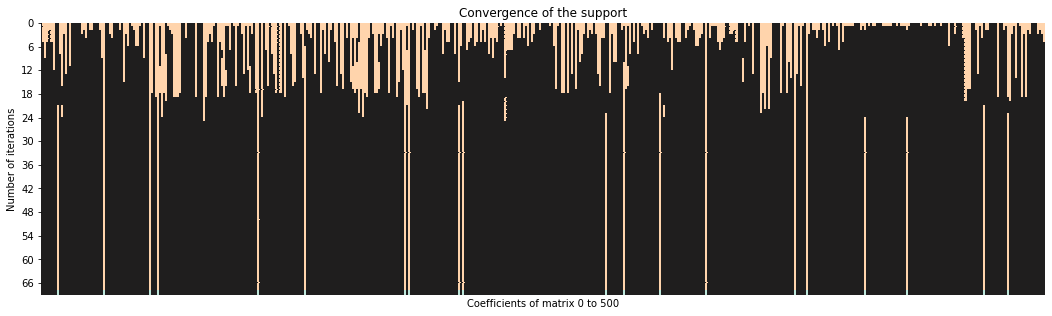

In [21]:
n_iter = len(logging["support"])
plt.figure(figsize=(18,5))
sns.heatmap(np.array(np.append(np.int32(logging["support"]),
                               -np.reshape(adj_matrix.flatten(), (1,n*n)), axis=0)),
           center=0, cbar=False); 
plt.xticks([]); plt.yticks(np.arange(0, n_iter+1, step=n_iter//10), np.arange(0, n_iter+1, step=n_iter//10));
plt.xlim([0, 500])
plt.title("Convergence of the support")
plt.xlabel("Coefficients of matrix 0 to 500");
plt.ylabel("Number of iterations");

Thank you!